# Проект для "Цифры"

**Задача: разработать модель машинного обучения, которая предсказывает коэффицент восстановления золота из золотосодержащей руды.**

**Цель: модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.**

**План проекта:**
1. Обзор данных

2. Предобработка данных
    - Обработка пропусков
    - Обработка типов данных
    - Обработка дубликатов
    - Проверка расчёта эффективности обогащения
    - Обработка аномальных значений

3. EDA
    - Концентрация металлов на разных этапах обработки
    - Распределение размеров гранул сырья
    - Суммарная концентрация всех веществ на этапах обработки

4. Построение модели
    - Конструирование и выбор признаков
    - Cравнение метрик нескольких моделей машинного обучения.
    - Гиперпараметрическая настройка лучшей модели.
5. Тестовая выборка
    - Расчёт итоговой sMAPE
    - Интерпретация результатов работы модели

## Описание данных

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import pandas as pd
import numpy as np
from skimpy import skim

import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import IsolationForest

In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Описание процесса**

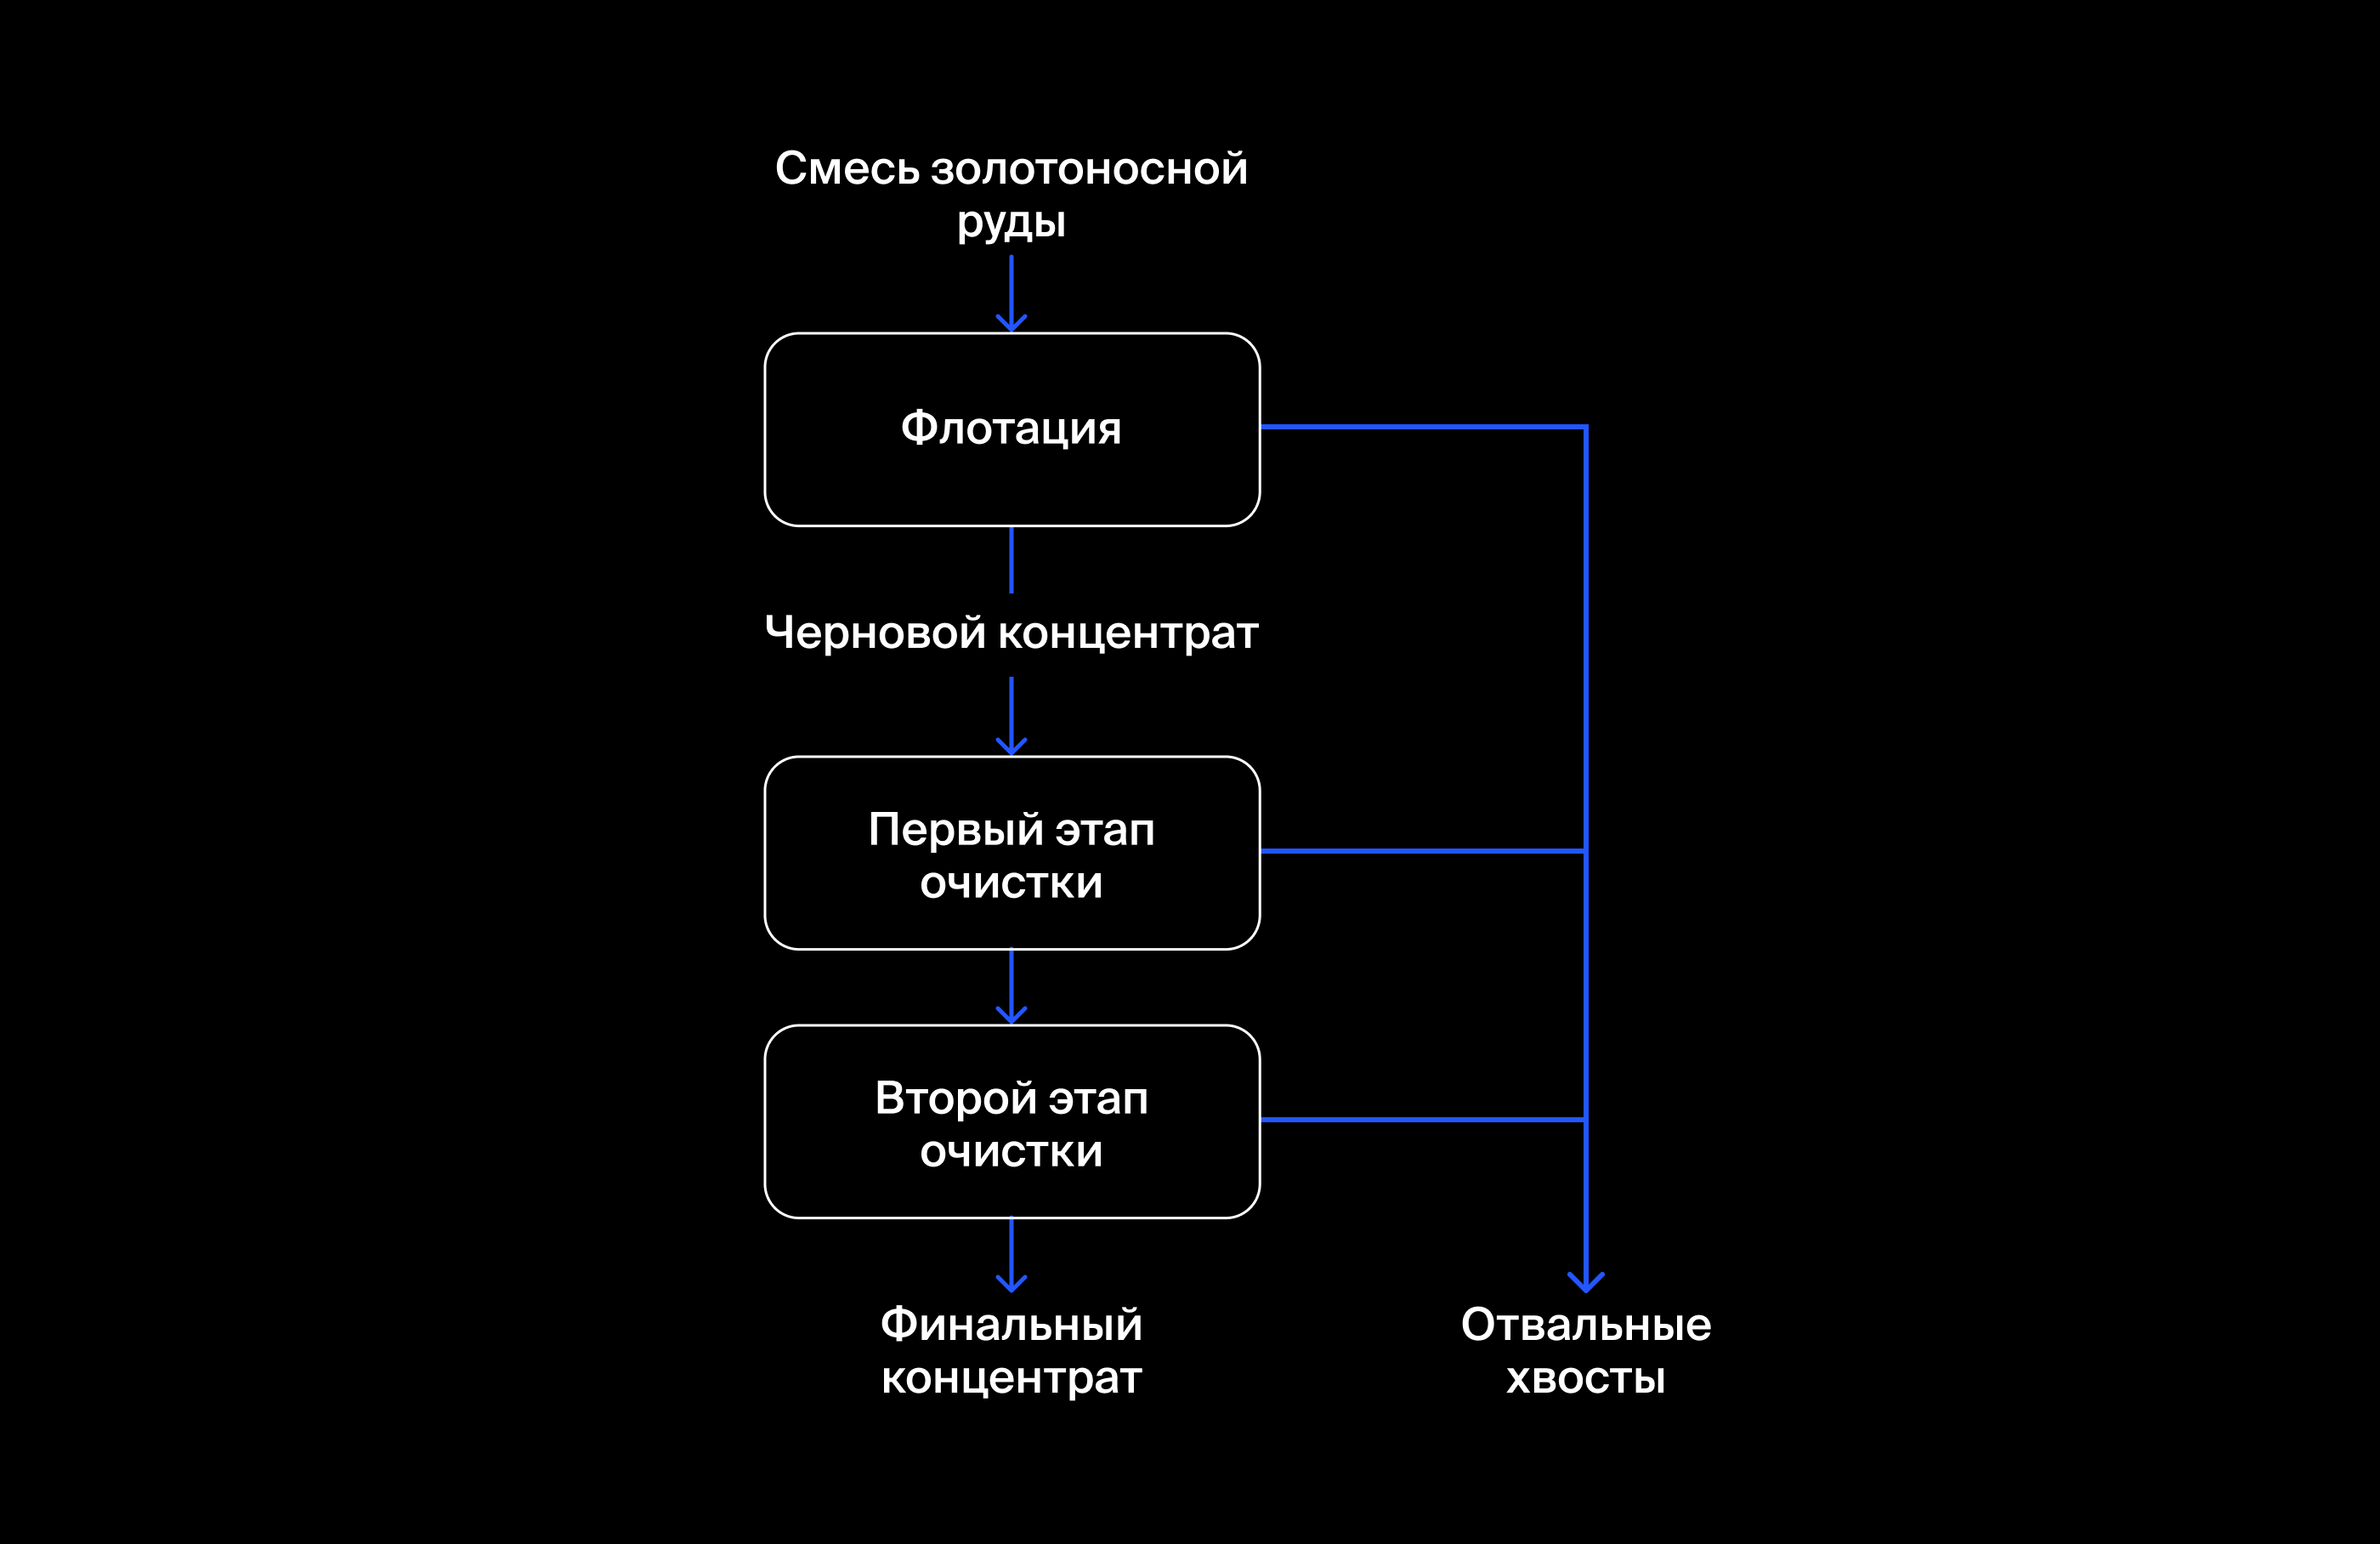

In [17]:
Image("D:/pic/process.jpg")

<b>1. Флотация</b>

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

<b> 2. Очистка</b>

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Описание данных**

Технологический процесс:

`Rougher feed` — исходное сырье

`Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

`Xanthate`— ксантогенат (промотер, или активатор флотации);

`Sulphate` — сульфат (на данном производстве сульфид натрия);

`Depressant` — депрессант (силикат натрия).

`Rougher process` (англ. «грубый процесс») — флотация

`Rougher tails` — отвальные хвосты

`Float banks` — флотационная установка

`Cleaner process` — очистка

`Rougher Au` — черновой концентрат золота

`Final Au` — финальный концентрат золота

Параметры этапов:
    
`air amount` — объём воздуха

`fluid levels` — уровень жидкости

`feed size` — размер гранул сырья

`feed rate` — скорость подачи

    Эффективность обогащения рассчитывается по формуле:
    
$$ Recovery = \frac{C (F - T)}{F (C - T)} 100 \% $$

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

В качетсве метрики касетва выбрана sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение») 

$$sMAPE = \frac{1}{N} \sum_{i = 1} \frac{2|y_i - y'_i|}{|y_i| + |y'_i|}$$,

где

$$y_i $$ - значение целевого признака i-го объекта
$$y'_i$$ - значение предсказания для i-го объекта
$$N$$ - кол-во объектов в выборке

**Итоговая метрика складывается из двух величин:**

$$ sMAPE = 25 \% sMAPE(rougher) + 75 \% sMAPE(final) $$

## Обзор данных

In [18]:
data_full = pd.read_csv('D:/datasets/gold_recovery_full_new.csv')
data_train = pd.read_csv('D:/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('D:/datasets/gold_recovery_test_new.csv')

In [19]:
skim(data_full)   

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 19439  │ │ float64     │ 86    │                                                          │
│ │ Number of columns │ 87     │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name            ┃ NA    ┃ NA %    ┃ mean   ┃ sd      ┃ p0        ┃ p25   ┃ p75   ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ final.output.concent   │     1 │  0.0051 │    5.2 │     1.4 │         0 │   4.3 │   5.9 │      16 │   █▅   │  │
│ │ final.output.concent   │     1 │  0.0051 │     10 │     1.7 │         0 │   9.1 │    11 │      17 │   ▁█▂  │  │
│ │ final.output.concent   │   210 │     1.1 │    9.5 │     2.8 │         0 │   7.7 │    11 │      20 │  ▁█▅▂  │  │
│ │ final.output.concent   │     0 │       0 │     44 │     5.1 │         0 │    43 │    46 │      53 │     ▃█ │  │
│ │ final.output.recover   │     0 │       0 │     67 │      10 │         0 │    63 │    73 │     100 │    ▅█  │  │
│ │ final.output.tail_ag   │     1 │  0.0051 │    9.7 │     2.3 │         0 │   8.1 │    11 │      20 │  ▁██▁  │  │
│ │ final.output.tail_pb   │   100 │    0.52 │    2.7 │    0.95 │         0 │     2 │   3.3 │     5.8 │ ▁▄█▇▂  │  │
│ │ final.output.tail_so   │     6 │   0.031 │     11 │     2.9 │         0 │   8.9 │    12 │      22 │  ▁█▆▁  │  │
│ │ final.output.tail_au   │     0 │       0 │      3 │    0.92 │         0 │   2.5 │   3.6 │     8.2 │   ▆█▁  │  │
│ │ primary_cleaner.inpu   │    24 │    0.12 │    140 │      44 │    0.0031 │   110 │   180 │     270 │  ▂▇█▄▁ │  │
│ │ primary_cleaner.inpu   │    37 │    0.19 │    8.8 │     3.3 │         0 │   6.1 │    11 │      40 │  ▄█▁   │  │
│ │ primary_cleaner.inpu   │     0 │       0 │    7.3 │    0.61 │       1.1 │   6.9 │   7.7 │      16 │    █   │  │
│ │ primary_cleaner.inpu   │   100 │    0.54 │      1 │    0.51 │   4.6e-06 │   0.7 │   1.2 │     4.1 │  ▃█▂   │  │
│ │ primary_cleaner.outp   │     0 │       0 │    8.4 │     2.1 │         0 │   7.3 │   9.8 │      16 │  ▁▆█▂  │  │
│ │ primary_cleaner.outp   │   120 │     0.6 │    9.8 │     2.6 │         0 │   8.7 │    11 │      17 │  ▁▃█▄  │  │
│ │ primary_cleaner.outp   │   370 │     1.9 │     10 │     3.9 │         0 │   7.9 │    13 │      22 │ ▁▄█▆▃  │  │
│ │ primary_cleaner.outp   │     0 │       0 │     32 │     5.6 │         0 │    30 │    35 │      46 │    ▃█▁ │  │
│ │ primary_cleaner.outp   │     4 │   0.021 │     16 │     3.5 │         0 │    14 │    18 │      29 │   ▅█▂  │  │
│ │ primary_cleaner.outp   │    21 │    0.11 │    3.4 │     1.4 │         0 │   2.5 │   4.2 │     9.6 │ ▁█▇▂▁  │  │
│ │ primary_cleaner.outp   │    62 │    0.32 │      8 │     2.2 │         0 │   6.7 │   9.5 │      22 │  ▁▄█▁  │  │
│ │ primary_cleaner.outp   │     0 │       0 │    3.9 │     1.6 │         0 │   2.9 │   4.6 │      18 │  ▃█▁   │  │
│ │ primary_cleaner.stat   │     4 │   0.021 │   1600 │     130 │   5.4e-32 │  1500 │  1700 │    2100 │    ▁█▁ │  │
│ │ primary_cleaner.stat   │     1 │  0.0051 │   -490 │ 

In [20]:
skim(data_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 14149  │ │ float64     │ 86    │                                                          │
│ │ Number of columns │ 87     │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name            ┃ NA    ┃ NA %    ┃ mean   ┃ sd      ┃ p0        ┃ p25   ┃ p75   ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ final.output.concent   │     1 │  0.0071 │    5.1 │     1.4 │         0 │   4.2 │   5.9 │      16 │   █▅   │  │
│ │ final.output.concent   │     1 │  0.0071 │     10 │     1.7 │         0 │   9.3 │    11 │      17 │   ▁█▂  │  │
│ │ final.output.concent   │   210 │     1.5 │    9.2 │     2.8 │         0 │   7.5 │    10 │      18 │  ▁█▅▂▁ │  │
│ │ final.output.concent   │     0 │       0 │     44 │     4.9 │         0 │    43 │    46 │      53 │     ▄█ │  │
│ │ final.output.recover   │     0 │       0 │     67 │      10 │         0 │    63 │    72 │     100 │   ▁▆█  │  │
│ │ final.output.tail_ag   │     0 │       0 │    9.6 │     2.3 │         0 │     8 │    11 │      20 │  ▁█▆▁  │  │
│ │ final.output.tail_pb   │   100 │    0.71 │    2.6 │    0.97 │         0 │   1.9 │   3.2 │     5.6 │ ▁▅█▆▂  │  │
│ │ final.output.tail_so   │     5 │   0.035 │     11 │       3 │         0 │   8.8 │    12 │      22 │  ▁█▅▁  │  │
│ │ final.output.tail_au   │     0 │       0 │    2.9 │     0.9 │         0 │   2.4 │   3.4 │     8.2 │   ▇█▁  │  │
│ │ primary_cleaner.inpu   │    20 │    0.14 │    130 │      39 │    0.0031 │   110 │   160 │     250 │  ▂▇█▄▁ │  │
│ │ primary_cleaner.inpu   │    32 │    0.23 │    8.9 │     3.4 │         0 │     6 │    12 │      20 │ ▁▆█▅▂  │  │
│ │ primary_cleaner.inpu   │     0 │       0 │    7.3 │    0.61 │       1.1 │     7 │   7.7 │      10 │    █▇  │  │
│ │ primary_cleaner.inpu   │   100 │    0.71 │   0.89 │    0.37 │   4.6e-06 │  0.61 │   1.1 │     2.5 │ ▂██▃▁  │  │
│ │ primary_cleaner.outp   │     0 │       0 │    8.2 │       2 │         0 │   7.1 │   9.5 │      16 │  ▁▇█▁  │  │
│ │ primary_cleaner.outp   │    86 │    0.61 │    9.6 │     2.7 │         0 │   8.3 │    11 │      17 │  ▁▃█▃  │  │
│ │ primary_cleaner.outp   │   290 │       2 │     10 │     4.1 │         0 │   7.5 │    13 │      22 │ ▁▄█▅▃  │  │
│ │ primary_cleaner.outp   │     0 │       0 │     32 │     5.8 │         0 │    31 │    35 │      46 │    ▂█▁ │  │
│ │ primary_cleaner.outp   │     1 │  0.0071 │     16 │     3.7 │         0 │    14 │    18 │      29 │   ▆█▃  │  │
│ │ primary_cleaner.outp   │    15 │    0.11 │    3.4 │     1.5 │         0 │   2.4 │   4.3 │     9.6 │ ▁█▆▂▁  │  │
│ │ primary_cleaner.outp   │    46 │    0.33 │    7.5 │     2.1 │         0 │   6.3 │   8.9 │      21 │  ▁▄█▁  │  │
│ │ primary_cleaner.outp   │     0 │       0 │    3.8 │     1.6 │         0 │   2.9 │   4.5 │      18 │  ▄█▁   │  │
│ │ primary_cleaner.stat   │     4 │   0.028 │   1600 │     130 │    0.0064 │  1600 │  1700 │    2100 │     █▁ │  │
│ │ primary_cleaner.stat   │     1 │  0.0071 │   -490 │ 

In [21]:
skim(data_test)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5290   │ │ float64     │ 52    │                                                          │
│ │ Number of columns │ 53     │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA  ┃ NA %    ┃ mean   ┃ sd     ┃ p0        ┃ p25   ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ primary_cleaner.inpu       │   4 │   0.076 │    170 │     43 │       2.6 │   150 │   210 │   270 │  ▁▃▇█▃  │  │
│ │ primary_cleaner.inpu       │   5 │   0.095 │    8.7 │    3.1 │    0.0038 │   6.5 │    10 │    40 │   ▄█▁   │  │
│ │ primary_cleaner.inpu       │   0 │       0 │    7.3 │   0.61 │       5.7 │   6.9 │   7.6 │    16 │   █▇    │  │
│ │ primary_cleaner.inpu       │   4 │   0.076 │    1.4 │   0.64 │     0.005 │  0.91 │   1.8 │   4.1 │  ▁█▄▂   │  │
│ │ primary_cleaner.stat       │   0 │       0 │   1500 │    120 │   5.4e-32 │  1500 │  1600 │  2100 │     ▂█  │  │
│ │ primary_cleaner.stat       │   0 │       0 │   -500 │     20 │      -800 │  -500 │  -500 │   -57 │     █   │  │
│ │ primary_cleaner.stat       │   0 │       0 │   1500 │    120 │   6.6e-32 │  1500 │  1600 │  1800 │     ▅█  │  │
│ │ primary_cleaner.stat       │   0 │       0 │   -500 │     33 │      -800 │  -500 │  -500 │  -140 │     █   │  │
│ │ primary_cleaner.stat       │   0 │       0 │   1500 │    120 │     4e-32 │  1500 │  1600 │  1700 │     ▂█  │  │
│ │ primary_cleaner.stat       │   0 │       0 │   -500 │     22 │      -800 │  -500 │  -500 │  -150 │     █   │  │
│ │ primary_cleaner.stat       │   0 │       0 │   1500 │    120 │     4e-32 │  1500 │  1600 │  1900 │     ██  │  │
│ │ primary_cleaner.stat       │   0 │       0 │   -500 │     31 │      -800 │  -500 │  -500 │  -160 │     █   │  │
│ │ rougher.input.feed_a       │   0 │       0 │    9.4 │    1.9 │      0.57 │   8.1 │    11 │    14 │   ▃▆█▁  │  │
│ │ rougher.input.feed_p       │   0 │       0 │    3.8 │   0.95 │      0.27 │   3.2 │   4.3 │   6.9 │   ▁▆█▃  │  │
│ │ rougher.input.feed_r       │   3 │   0.057 │    490 │    110 │     0.003 │   410 │   580 │   710 │   ▁▇█▅  │  │
│ │ rougher.input.feed_s       │   1 │   0.019 │     56 │     19 │     0.046 │    44 │    62 │   390 │   █▂    │  │
│ │ rougher.input.feed_s       │  21 │     0.4 │     38 │    5.5 │       1.4 │    35 │    42 │    53 │    ▅█▁  │  │
│ │ rougher.input.feed_a       │   0 │       0 │    9.3 │    1.6 │      0.57 │   8.2 │    10 │    14 │   ▂▅█▁  │  │
│ │ rougher.input.floatb       │   5 │   0.095 │     14 │    3.4 │    0.0011 │    12 │    17 │    24 │   ▁▆█▅  │  │
│ │ rougher.input.floatb       │   0 │       0 │    6.5 │    1.1 │   0.00057 │     6 │   7.1 │   8.9 │    ▃█▂  │  │
│ │ rougher.input.floatb       │   8 │    0.15 │     14 │    3.2 │   7.7e-05 │    12 │    17 │    24 │   ▁▅█▅  │  │
│ │ rougher.input.floatb       │  25 │    0.47 │    6.5 │   0.89 │     0.007 │     6 │   7.1 │   8.6 │    ▂█▃  │  │
│ │ rougher.state.floatb       │   0 │       0 │   1100 

### Вывод по первичному обзору данных

- заметно много пропусков в столбцах
- столбец с датой лучше перевести в datetime, все остальные признаки численные и их типы данных корректны
- в таблице с тестовыми данными отсутвуют признаки, которое есть в тренировочных и исходных данных, рассмотрю признаки конкретнее:    

    - `rougher.output.concentrate_au` те концентрация золота  (и других металлов ; pb, ag, sol)в продукте на этапе флотации, а есть только `rougher.input.feed_au` те концентрация золота и других металлов до обработки
    - `rougher.output.tail_au` так же отсутсвует,  скорее всего говорящий о концентрации металла в отвальных хвостах
    - все признаки с типом параметра `output` те после флотации/очистки, соответсвенно, модели нудно уметь предсказывать на данных, полученных до этих этапов
    
Получается, что в тестовой выборке отсутсвуют любые данные о полученном продукет, есть только данные о текущем состоянии этапа `state` и данные об исходном сырье `input`, вероятнее всего это связано с тем, что данные не должны быть известны на данном этапе

Нашла параметры, требуемые для расчёта эффективности обогащения сырья:
- доля золота в концентрате после флотации `С` - `rougher.output.concentrate_au`
- доля золота в сырье те до флотации `F` - `rougher.input.feed_au`
- доля золота в отвальных хвостах после флотафии `T` - `rougher.output.tail_au`
- `rougher.output.recovery`  эффективность обогащения

## Предобработка данных

### Обработка пропусков

Для заполнения пропущенных значений, я буду использовать предыдущие значения

In [22]:
data_train = data_train.fillna(method= 'bfill')
data_test = data_test.fillna(method= 'bfill')
data_full = data_full.fillna(method= 'bfill')

### Обработка типов данных

In [23]:
print(data_full.dtypes, data_train.dtypes, data_test.dtypes, sep= '\n' *3)

date                                                   string
final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.input.sulfate                         float64
primary_cleaner.input.depressant                      float64
primary_cleaner.input.feed_size                       float64
primary_cleaner.input.xanthate                        float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_

В таблицах корретные типы данных за исключением столбцов  с датой.

In [24]:
data_full['date'] = pd.to_datetime(data_full['date'], format= '%Y-%m-%d %H:%M:%S')
data_train['date'] = pd.to_datetime(data_train['date'], format= '%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format= '%Y-%m-%d %H:%M:%S')

### Обработка дубликатов

In [25]:
print(data_train.duplicated().sum(),
    data_full.duplicated().sum(),
    data_test.duplicated().sum())

0 0 0


### Проверка эффективности расчёта обогащения

In [26]:
def check_calc(data, c, f, t, recovery):
    calc_recovery = (data[c] * (data[f] - data[t]))/(data[f] * (data[c] - data[t])) *100
    data_recovery = data[recovery]
    mae = mean_absolute_error(calc_recovery, data_recovery)
    return mae

In [27]:
check_calc(
data_full, 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery')

9.874045668302637e-15

Отклонения в расчётах настолько малы, что ими можно пренебречь.

### Обработка аномальных значений

In [28]:
data_train.head()

date  final.output.concentrate_ag  \
0 2016-01-15 00:00:00                     6.055403   
1 2016-01-15 01:00:00                     6.029369   
2 2016-01-15 02:00:00                     6.055926   
3 2016-01-15 03:00:00                     6.047977   
4 2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  \
0              0.895447              16.904297              2.143149   
1              0.927452              16.634514              2.224930   
2              0.953716              16.208849              2.257889   
3              0.883763              16.532835              2.146849   
4              0.792826              16.525686              2.055292   

   primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                     127.092003                         10.128295   
1                     125.629232                         10.296251   
2                     123.819808                         11.316280   
3                     122.270188                         11.322140   
4                     117.988169                         11.913613   

   primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                             7.25                        0.988759   
1                             7.25                        1.002663   
2                             7.25                        0.991265   
3                             7.25                        0.996739   
4                             7.25                        1.009869   

   primary_cleaner.output.concentrate_ag  \
0                               8.547551   
1                               8.558743   
2                               8.603505   
3                               7.221879   
4                               9.089428   

   primary_cleaner.output.concentrate_pb  \
0                              10.389648   
1                              10.497069   
2                              10.354494   
3                               8.496563   
4                               9.986786   

   primary_cleaner.output.concentrate_sol  \
0                               19.529297   
1                               19.369147   
2                               19.167579   
3                               15.978538   
4                               19.199864   

   primary_cleaner.output.concentrate_au  primary_cleaner.output.tail_ag  \
0                              34.174427                       14.936526   
1                              34.118526                       16.250511   
2                              33.969464                       16.491823   
3                              28.260743                       16.024359   
4                              33.044932                       16.480185   

   primary_cleaner.output.tail_pb  primary_cleaner.output.tail_sol  \
0                        2.534912                         7.476074   
1                        3.049646                         6.733907   
2                        3.124664                         6.471768   
3                  

In [35]:
data = data_train[:1000].drop(['date'], axis = 1)

<AxesSubplot: >

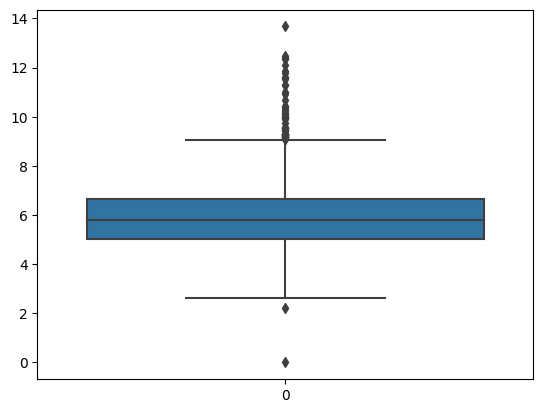

In [33]:
sns.boxplot(data['final.output.concentrate_ag'])

In [47]:
if_sk = IsolationForest(n_estimators = 100, 
                        max_samples = 256, 
                        random_state= 42)
if_sk.fit(data)

IsolationForest(max_samples=256, random_state=42)

In [48]:
pred_y = if_sk.predict(data)

In [50]:
pred_y = [1 if x == -1 else 0 for x in pred_y]
pred_y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [56]:
data_clean = data.drop(pred_y, axis = 0)

In [57]:
len(data_clean)

998

In [58]:
sns.boxplot(data_clean['final.output.concentrate_ag'])

KeyError: 0

In [55]:
data_clean

final.output.concentrate_ag  final.output.concentrate_pb  \
2                       6.055926                    10.213995   
3                       6.047977                     9.977019   
4                       6.148599                    10.142511   
5                       6.482968                    10.049416   
6                       6.533849                    10.058141   
7                       6.130823                     9.935481   
8                       5.834140                    10.071156   
9                       5.687063                     9.980404   
10                      5.706261                    10.242511   
11                      5.582300                    10.029878   
12                      5.664983                    10.168953   
13                      5.474776                     9.813218   
14                      5.437716                     9.781181   
15                      5.454277                    10.019066   
16                      5.410126                    10.868937   
17                      5.572499                    10.841483   
18                      5.719113                    10.621027   
19                      5.658943                    10.436002   
20                      5.682227                    10.659174   
21                      5.935933                    10.755414   
22                      6.118749                    10.483007   
23                      5.723934                     9.885626   
24                      5.522219                    10.333510   
25                      5.869183                    10.226782   
26                      5.731578                     9.420766   
27                      5.572978                     9.477411   
28                      5.276736                     9.601490   
29                      5.286902                     9.832614   
30                      5.322681                     9.577672   
31                      5.401347                     9.431061   
32                      5.247819                     8.812578   
33                      5.105161                     8.917370   
34                      5.090817                     9.390164   
35                      5.300845                     9.718419   
36                      5.481415                    10.188854   
37                      5.549286                    10.042133   
38                      5.418940                    10.211518   
39                      5.452612                    10.663721   
40                      5.401283                    10.437578   
41                      5.718407                     9.931067   
42                      5.774138                     9.606699   
43                      5.110753                    10.726356   
44                      4.681668                    10.491870   
45                      4.566664                    10.406178   
46                      4.577832                    10.691605   
47                      4.591462                    10.628846   
48                      5.296830                    10.597469   
49                      8.162896                     8.877528   
50                      5.759800                     9.537415   
51                      5.807253                    10.439505   
52                      5.311343                    11.675848   
53                      4.936983                    11.510876   
54                      4.562255                    11.015968   
55                      4.498173                    10.570763   
56                      4.841728                    10.625456   
57                      4.694925                    10.619857   
58                      4.899785                    11.187794   
59                      5.222798                    12.439519   
60                      5.935189                    11.986658   
61                      6.272587                    11.723778   
62                      5.466005        